### Главна скрипта за примену ТоМАТо алгоритма на тродимензионални синтетички скуп података

In [1]:
%run imports.ipynb

Генеришемо тродимензионални синтетички скуп података тако што позивамо скрипту plot_3d.ipynb која нам враћа два скупа тачака на концентричним сферама.

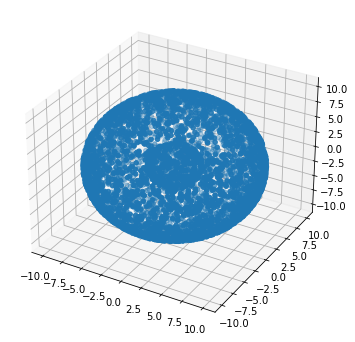

In [2]:
%run plot_3d.ipynb

In [3]:
x = points_1 + points_2
x = np.asarray(x)
x.shape

(5000, 3)

У скрипти estimate_density2.ipynb оцењујемо функцију густине помоћу Гаусовог кернела. Ширину кернела бирамо 10-слојном унакрсном валидацијом.

{'bandwidth': 2.0}


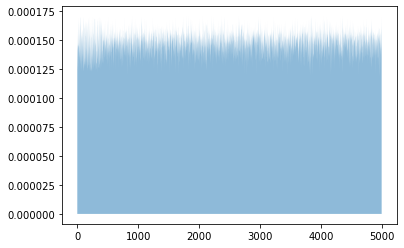

In [4]:
%run estimate_density2.ipynb

In [5]:
vec

array([0.00015822, 0.00012497, 0.00012802, ..., 0.00013489, 0.00016271,
       0.00015419])

In [6]:
min(vec), max(vec)

(0.00011824463913398482, 0.0001707215400354944)

In [7]:
x

array([[-1.30193702, -1.22305027,  2.41020913],
       [-1.12712336,  2.59595686, -0.99528936],
       [ 0.32683738,  1.21403913, -2.72383669],
       ...,
       [ 8.35602907, -4.73469167, -2.78558307],
       [-9.06676869,  2.96251316,  3.00286885],
       [ 8.70177755,  0.16525506,  4.92460742]])

Правимо KDTree структуру коју ћемо користити за израчунавање Рипсовог графа и надниво филтрације у имплементацији алгоритма.

In [8]:
kdt = KDTree(x, metric='euclidean')

Конструишемо дендрограм помоћу single linkage методе кластеровања.

In [9]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(x, 'single')

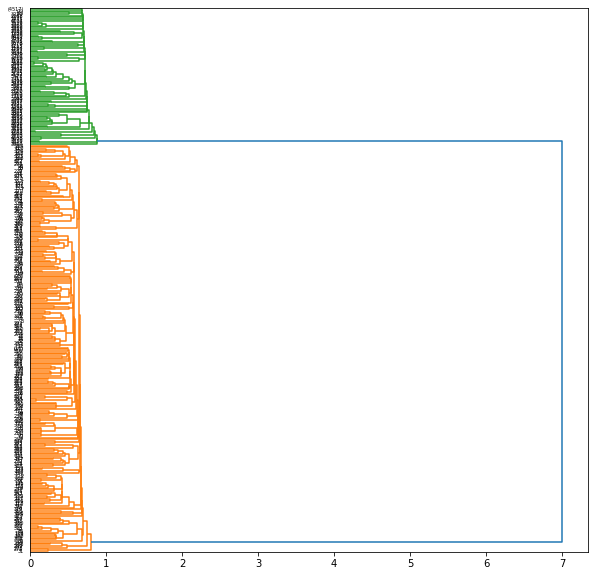

In [10]:
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, p=30,truncate_mode='level', orientation='right')

На основу релевантне скале добијене дендрограмом правимо график зависности просечног броја суседа од радијуса у Рипсовом графу и примењујемо методу лакта за финални избор параметра.

In [11]:
rads = np.linspace(0, 7, 20)
count_neis = [np.mean([kdt.query_radius([x[i]], rads[j], return_distance=False)[0].shape[0] for i in np.arange(x.shape[0])]) 
           for j in range(len(rads))]

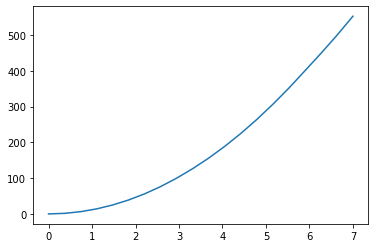

In [12]:
%matplotlib inline
plt.plot(rads, count_neis)

In [11]:
radius = 3

Пре покретања алгоритма иницијализујемо дисјунктни-сет структуру и сортирамо индексе тачака у подацима по опадајућој вредности функције густине.

In [12]:
%run unionfind.ipynb

In [13]:
index_sorted = np.asarray([i for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])])
vec_sorted = {i:e for (e,i) in sorted([(e,i) for i,e in enumerate(vec)])}
vec_sorted

{4962: 0.00011824463913398482,
 3832: 0.00011859160390245574,
 2776: 0.00011873476756142106,
 3450: 0.00011882377459728597,
 832: 0.00011917253464101512,
 3834: 0.00011924364514568759,
 4612: 0.00011929622671726816,
 1310: 0.0001193660523483852,
 3870: 0.00011942059607212099,
 1660: 0.00011950079844866281,
 2752: 0.00011968513396433609,
 2949: 0.00011986382756313247,
 4159: 0.00011987584275020992,
 4899: 0.00012024324269276497,
 3819: 0.0001206593009322246,
 1520: 0.00012104916713938474,
 1614: 0.00012120579046839995,
 66: 0.0001215224944936622,
 3371: 0.00012155528371029365,
 527: 0.00012192989632195639,
 339: 0.00012195633089481705,
 3983: 0.00012199927549895172,
 4356: 0.000122052417279667,
 21: 0.0001221135572016865,
 328: 0.00012217721771206404,
 4985: 0.00012223541451028113,
 310: 0.00012225440194302357,
 1377: 0.00012235747137234157,
 239: 0.0001223794706241095,
 4173: 0.00012266618844553322,
 256: 0.0001228530966173434,
 168: 0.0001228867189178562,
 205: 0.0001229143297924311,


Главна функција за имплементацију ТоМАТо алгоритма која враћа хијерархију кластера:

In [14]:
def define_clusters(vec_sorted, radius, tau):

    unf = UnionFind()
    n=len(vec)
    births = {}
    deaths = {}
    for i in reversed(range(n)):
        idx = index_sorted[i]
        nei = kdt.query_radius([x[idx]], radius, return_distance=False)[0]
        S = [elem for elem in nei if elem in index_sorted[(i+1):]] 

        if not S:
            unf.insert_objects([idx]) 
            births[idx] = -vec_sorted[idx]
        else:
            parent = S[np.asarray([vec_sorted[j] for j in S]).argmax()]
            unf.union(parent, idx)
            roots = [unf.find(ele) for ele in S]
            highest = roots[np.asarray([vec_sorted[elem] for elem in roots]).argmax()]
            for root in roots:                   
                if (root != parent) & (vec_sorted[root] - vec_sorted[idx] < tau):
                    unf.union(parent, root)
                    deaths[root] = -vec_sorted[idx]
            if (highest != parent) & (vec_sorted[parent] - vec_sorted[idx] < tau):
                unf.union(highest, parent)
                deaths[parent] = -vec_sorted[idx]
    return unf, births, deaths

Прво покрећемо алгоритам за бесконачну вредност параметра спајања да бисмо добили значајност сваке моде функције густине.

In [15]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau=np.inf)

На оснoву излаза првог покретања алгоритма рачунамо животне векове свих мода и на затим конструишемо хистограм значајности, перзистентни дијаграм и перзистентни бар-код.

In [16]:
for idx in list(births.keys()):
    if (idx not in list(deaths.keys())):
        deaths[idx] = np.inf

In [17]:
lifecycle = [(births[idx], deaths[idx]) for idx in list(births.keys())]

In [18]:
res = [(0, elem) for elem in lifecycle]
res

[(0, (-0.0001707215400354944, -0.00015292509561661287)),
 (0, (-0.00017005948861189283, -0.0001215224944936622)),
 (0, (-0.00016389566303183934, -0.00014105172433402522)),
 (0, (-0.0001623256128296954, -0.0001471545533801932)),
 (0, (-0.00015972764925388614, -0.00015065648750775125)),
 (0, (-0.0001593922575129385, -0.00014052255337583636)),
 (0, (-0.00015886325709409157, -0.00013449589664570258)),
 (0, (-0.0001585628808144322, -0.00014733434357229764)),
 (0, (-0.00015837527260110704, -0.00011824463913398482)),
 (0, (-0.0001564098948631418, -0.00014157804324666344)),
 (0, (-0.00015103628883719706, -0.0001362006095480983)),
 (0, (-0.00014839510681961688, -0.00013695407878233602))]

In [19]:
persistence = [elem[1]-elem[0] for elem in lifecycle]
persistence

[1.779644441888154e-05,
 4.853699411823063e-05,
 2.2843938697814125e-05,
 1.51710594495022e-05,
 9.071161746134886e-06,
 1.886970413710214e-05,
 2.4367360448388983e-05,
 1.122853724213455e-05,
 4.013063346712222e-05,
 1.4831851616478353e-05,
 1.4835679289098755e-05,
 1.1441028037280859e-05]

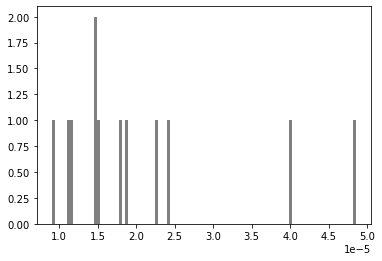

In [20]:
%matplotlib inline
plt.hist([elem for elem in persistence if ~np.isinf(elem)], bins=100, color = 'gray')
plt.show()

In [21]:
lifecycle_mod = [(-elem[0], 0) if elem[1]==np.inf else (-elem[0], -elem[1]) for elem in lifecycle]

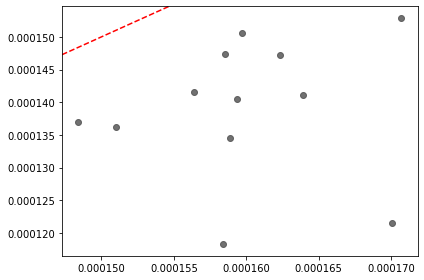

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter([elem[0] for elem in lifecycle_mod], [elem[1] for elem in lifecycle_mod], c=".3", alpha=0.8)
add_identity(ax, color='r', ls='--')
plt.tight_layout()
plt.show()

usetex mode requires TeX.


<Figure size 1296x288 with 0 Axes>

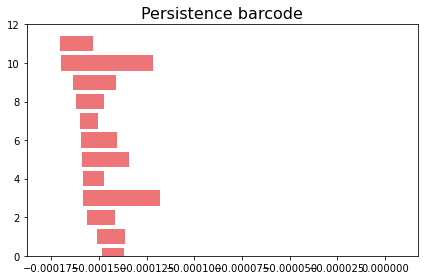

In [23]:
plt.figure(figsize=(18, 4))
fig = gds.GridSpec(1, 1)
gudhi.plot_persistence_barcode(res)
plt.tight_layout()
plt.show()

Покрећемо алгоритам други пут са новим параметром спајања добијеним на основу претходних визуализација.

In [24]:
unf, births, deaths = define_clusters(vec_sorted, radius=radius, tau = 3.5e-5)

Број родитеља у дисјунктни-сет структури нам даје тачан број кластера.

In [25]:
len(np.unique(list(unf.parent_pointers.values())))

3

Правимо центроиде кластера и одређујемо припадност сваке тачке добијеним кластерима .

In [26]:
cen, sts = [], []
ind = np.asarray(list(unf.num_to_objects.values()))
rts = np.asarray(list(unf.parent_pointers.values()))

In [27]:
for ele in np.unique(rts):

    cen.append(unf.num_to_objects[ele])
    sts.append(ind[np.where(rts == ele)[0]])

In [28]:
cen = np.asarray(cen)

In [29]:
cen

array([4348,  108, 3755])

In [30]:
sts

[array([1792, 2651, 2201, 1823,  902, 2372, 2063, 4045, 3843, 4995, 1058,
        2969, 1750, 4088, 2421, 2233,  511, 1054,  778, 1617, 4315, 1243,
        3579, 4757, 2662, 3616, 4116, 4826, 1112, 3012, 3919, 1884, 4026,
        3818, 1139, 3530, 1517, 3418, 4141, 1056, 3247, 2077, 3574, 3942,
        4153, 2245, 3714, 4839, 1734, 2221, 4063, 4543,  889, 3669, 3534,
        1324, 1943, 2972, 2408,  561, 3748, 2596, 2657, 4421, 3722, 4463,
        3854, 2081,  837, 4293, 4787]),
 array([108, 252, 202,  53,  96, 369, 371, 177,  17, 359, 388,  54, 351,
        262, 290, 375, 291, 332, 382, 393, 289, 242, 235, 139, 298, 282,
        399, 397, 361,  57,  20, 145, 130, 331, 170,  32, 199, 212, 178,
        156, 326,  50, 160,  37, 120,  67, 109, 255, 340, 146, 193, 151,
        264, 327,  56, 270, 315, 121, 124, 163, 129,  35, 122, 107,  82,
         52,  79, 353, 229, 214, 104,  88,  94,   0,  63, 337, 321, 398,
        309, 266,  41,  76,  80,  99, 136, 171,  11, 395, 225, 383, 358,
     

Рачунамо кардиналности кластера при чему задајемо минимални праг.

In [31]:
threshold = 50
cluster_size = []
i=0
for elem in sts:
    if len(elem) > threshold:
        i=i+1
    print(len(elem))
    cluster_size.append(len(elem))
print('Broj klastera vecih od ', threshold,' je ',i)

71
400
4529
Broj klastera vecih od  50  je  3


Правимо насумичне боје кластера за визуализацију финалног резултата при чему кластере кардиналности мање од минималног прага бојимо црном бојом.

In [32]:
colors = []
def cluster_color(cen):
    for i in np.arange(len(cen)):
        if (cluster_size[i] > threshold):
            np.random.seed(i)
            colors.append(list(np.random.choice(range(256), size=3,)/255))
        else:
            colors.append([0, 0, 0])
    return colors
colors = cluster_color(cen)

Финални резултат ТоМАТо алгоритма:

<IPython.core.display.Javascript object>


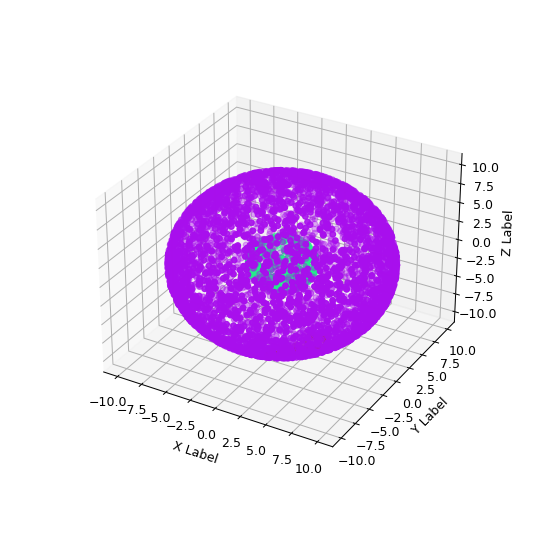

Text(0.5, 0, 'Z Label')

In [33]:
%matplotlib notebook
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
for idx, grp in enumerate(sts): 
    ax.scatter3D(x[grp, 0], x[grp, 1], x[grp, 2], 
                 label='Cluster {}'.format(idx), color = colors[idx])
    #ax.scatter3D(x[cen, 0], x[cen, 1], x[cen, 2],c='black', marker='x', label='Centroids', s = 500)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')